# Reparametrization test
In which cases model reparametrization is useful?

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# !nvidia-smi
# numpyro.set_platform("gpu")

import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.1' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from functools import partial

import jax
from jax import numpy as jnp, random as jr, jit, vmap, grad, debug
from jax.tree_util import tree_map

import numpyro
from numpyro import distributions as dist, sample, deterministic, infer, plate
from numpyro.handlers import seed, condition, trace

%matplotlib inline
%load_ext autoreload 
%autoreload 2

dphppce115.extra.cea.fr
cpu [CpuDevice(id=0)]


## Standard vs. unstandard param

### Define and reparametrize model

2024-04-02 12:37:23.905548: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


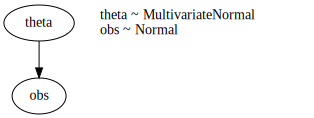

In [ ]:
def model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    theta = sample('theta', dist.MultivariateNormal(loc=mean, covariance_matrix=covar))
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

from numpyro.infer.util import log_density
logp_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta': xxyy_ij,
                                                'obs': obs},)[0]
logp_vfn = jit(vmap(vmap(logp_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=model,
    render_distributions=True,
    render_params=True,)

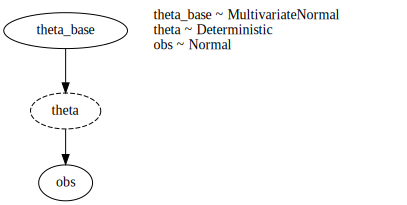

In [ ]:
def reparam_model(mean=jnp.zeros(2), covar=jnp.eye(2), vec=jnp.ones(2), epsilon=1):
    dim = len(mean)
    theta_base = sample('theta_base', dist.MultivariateNormal(loc=jnp.zeros(dim), covariance_matrix=jnp.eye(dim)))
    L = jax.scipy.linalg.cholesky(covar)
    theta = deterministic('theta', L @ theta_base + mean)
    proj = vec @ theta
    # obs = sample('obs', dist.Uniform(-epsilon + proj, epsilon + proj) )
    obs = sample('obs', dist.Normal(proj, epsilon) )
    return obs

logp_rep_fn = lambda xxyy_ij, obs, model_kwargs: log_density(model=reparam_model, 
                                        model_args=(), 
                                        model_kwargs=model_kwargs, 
                                        params={'theta_base': xxyy_ij,
                                                'obs': obs},)[0]
logp_rep_vfn = jit(vmap(vmap(logp_rep_fn, in_axes=(0,None,None)), in_axes=(0,None,None)))

numpyro.render_model(
    model=reparam_model,
    render_distributions=True,
    render_params=True,)

### Plot posteriors

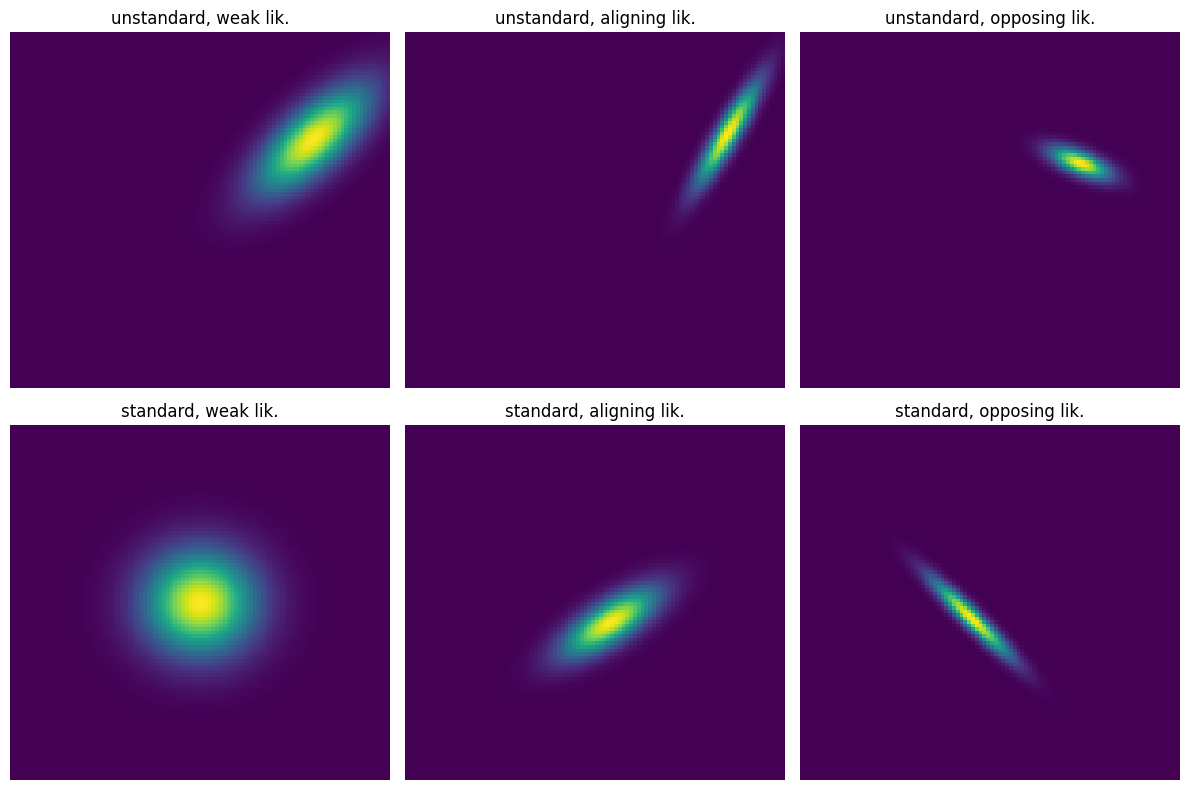

: 

In [11]:
angle = jnp.pi/4
model_kwargs = {'mean':jnp.array([2,3]), 
                'covar':jnp.array([[1,jnp.cos(angle)],[jnp.cos(angle),1]]),}

box_corner = 5
n_discr = 100
box = np.array([[-box_corner, box_corner], [-box_corner, box_corner]])
xxyy = np.mgrid[[slice(box_ax[0],box_ax[1],n_discr*1j) 
                       for box_ax in box]]

axis_switch = "off"
obs = 5
plt.figure(figsize=(12,8))
model_kwargs['epsilon'] = 10
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(231)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, weak lik."), plt.axis(axis_switch)
plt.subplot(234)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, weak lik."), plt.axis(axis_switch)

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([-1,2])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(232)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, aligning lik."), plt.axis(axis_switch)
plt.subplot(235)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, aligning lik."), plt.axis(axis_switch)

model_kwargs['epsilon'] = .5
model_kwargs['vec'] = jnp.array([2,1])
zz = jnp.exp(logp_vfn(xxyy.T, obs, model_kwargs))
zz_rep = jnp.exp(logp_rep_vfn(xxyy.T, obs, model_kwargs))
plt.subplot(233)
plt.pcolormesh(xxyy[0], xxyy[1], zz, cmap='viridis')
plt.title("unstandard, opposing lik."), plt.axis(axis_switch)
plt.subplot(236)
plt.pcolormesh(xxyy[0], xxyy[1], zz_rep, cmap='viridis')
plt.title("standard, opposing lik."), plt.axis(axis_switch)
plt.tight_layout()
plt.savefig('standunstand_param.png', dpi=200, bbox_inches='tight')
plt.show()

### Conclusion
* In the case of a model where the parameters are equally constrained, i.e. the likelihood is aligned with the prior, then it is better to reparametrize.
* In the case of a model where the likelihood constrain parameters unequally, it can sometimes be better not to reparametrize.

## How NumPyro handles diverging?
* With MH: rejection
* With HMC/NUTS: `biject_to`, e.g. sigmoid

2024-04-22 21:13:09.027806: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


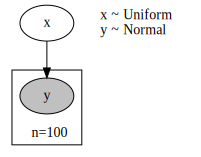

In [4]:
def model(n, high=1/2):
    x = sample('x', dist.Uniform(low=-1/2, high=high))
    with plate(f"n={n}", n):
        # y = sample('y', dist.Uniform(low=x-1/2, high=x+1/2))
        y = sample('y', dist.Normal(loc=x, scale=1))
    return y

n = 100
model = partial(model, n=n)
fiduc = {'x':0.49}
obs = {'y':seed(condition(model, fiduc), 42)()}
obs_model = condition(model, obs)
obs_model_uncons = partial(obs_model, high=10)

numpyro.render_model(obs_model, render_distributions=True, render_params=True,)

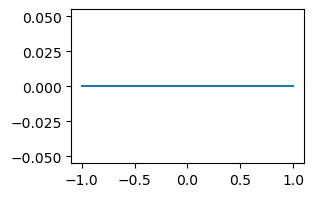

In [5]:
xs = jnp.linspace(-1,1)
plt.figure(figsize=(3,2))
plt.plot(xs, dist.Uniform(-1/2, 1/2).log_prob(xs))
plt.show()

In [8]:
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH
from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
def split_like(key, target):
    treedef = tree_structure(target)
    keys = jr.split(key, treedef.num_leaves)
    return tree_unflatten(treedef, keys)

def new_state_fn(state, key):
    # diffus = dist.Normal(jnp.zeros(1), 0.1*jnp.ones(1)).sample(key)
    # return tree_map(lambda x,y:x+y, state, [diffus])
    key_tree = split_like(key, state)
    diffus = tree_map(lambda x, k: dist.Normal(jnp.zeros_like(x), 0.1 * jnp.ones_like(x)).sample(k), state, key_tree)
    return tree_map(lambda x,y:x+y, state, diffus)

# Sample from posterior
mh_kernel = MH(model=obs_model_uncons, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples_uncons = mcmc.get_samples()
mcmc.print_summary()

mh_kernel = MH(model=obs_model, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples = mcmc.get_samples()
mcmc.print_summary()

/tmp/ipykernel_1862831/4089471456.py:2: DeprecationWarning: jax.tree_unflatten is deprecated: use jax.tree.unflatten (jax v0.4.25 or newer) or jax.tree_util.tree_unflatten (any JAX version).
  from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
/tmp/ipykernel_1862831/4089471456.py:2: DeprecationWarning: jax.tree_structure is deprecated: use jax.tree.structure (jax v0.4.25 or newer) or jax.tree_util.tree_structure (any JAX version).
  from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
sample: 100%|██████████| 11000/11000 [00:04<00:00, 2245.02it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.51      0.10      0.51      0.35      0.67   1006.13      1.00



sample: 100%|██████████| 11000/11000 [00:04<00:00, 2610.71it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.41      0.06      0.43      0.33      0.50     41.70      1.07



In [15]:
nuts_kernel = infer.NUTS(obs_model_uncons, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_uncons, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

nuts_kernel = infer.NUTS(obs_model, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

sample: 100%|██████████| 3850/3850 [00:10<00:00, 364.00it/s, 1 steps of size 1.17e+00. acc. prob=0.90]


total steps: 7890

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.51      0.10      0.51      0.34      0.66   1297.64      1.00

Number of divergences: 0


sample: 100%|██████████| 3850/3850 [00:08<00:00, 443.07it/s, 1 steps of size 9.02e-01. acc. prob=0.89]


total steps: 10750

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.42      0.06      0.44      0.34      0.50   1268.47      1.00

Number of divergences: 0


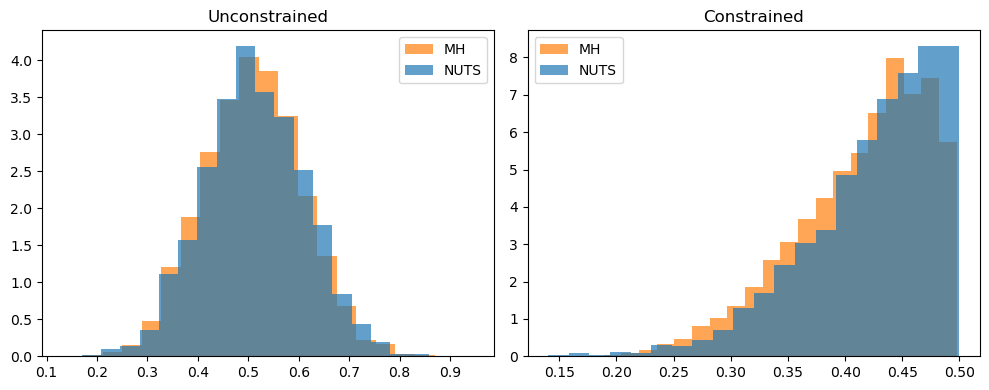

In [16]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(mh_samples_uncons['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples_uncons['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Unconstrained"), plt.legend()
plt.subplot(122)
plt.hist(mh_samples['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Constrained"), plt.legend()
plt.tight_layout(), plt.show();

## Domain reparam

### Naive Normal Truncation
#### Transport formula
Let be $X \sim \mathcal N(\mu, \sigma^2)$ and 
$Y \sim \mathcal N(\mu, \sigma^2, a, b)$. Then

$$F_X(X) = F_Y(Y) = U = \frac{F_X(Y) - F_X(a)}{F_X(b) - F_X(a)} \iff Y = F_X^{-1}(F_X(a) +  (F_X(b) - F_X(a))U)$$

#### Numerical instability
Problem arises when $|X| \gg \sigma$, then $F_X(X) \approx 1 \implies F_X^{-1}(F_X(X)) = X \approx +\infty$, where $\approx$ denotes computer approximation.
* With `float32`, this occurs for about $X > 5.4 \sigma$ $(\mathbb P\simeq 6 \times 10^{-8})$  and $X < -13.3 \sigma$ $(\mathbb P\simeq 9 \times 10^{-41})$
 
When sampling from Truncated Normal from uniform distribution, we work with $U \sim \mathcal U$ directly, such that instabilities from $F_X$ does not intervene. Numerical limit occurs only at $U > 1-10^{-17}$ and $U < 10^{-45}$.

In [2]:
from jax.scipy.stats import norm
print("Positive tail")
x = 5.419983
print("X:", x, "U:", norm.cdf(x), "Y:",norm.ppf(norm.cdf(x)))
x = 5.419984
print("X:", x, "U:",norm.cdf(x), "Y:",norm.ppf(norm.cdf(x)))
u = 1-1e-16
print("U:",u, "Y:",norm.ppf(u))
u = 1-1e-17
print("U:",u, "Y:",norm.ppf(u))
print("\nNegative tail")
x = -12.949
print("X:", x, "U:",norm.cdf(x), "Y:",norm.ppf(norm.cdf(x)))
x = -13.320
print("X:", x, "U:",norm.cdf(x), "Y:",norm.ppf(norm.cdf(x)))
x = -13.321
print("X:", x, "U:",norm.cdf(x), "Y:",norm.ppf(norm.cdf(x)))
u = 1e-45
print("U:",u, "Y:",norm.ppf(u))
u = 1e-46
print("U:",u, "Y:",norm.ppf(u))

Positive tail
X: 5.419983 U: 0.99999994 Y: 5.294704
X: 5.419984 U: 1.0 Y: inf
U: 0.9999999999999999 Y: 8.209537
U: 1.0 Y: inf

Negative tail
X: -12.949 U: 1.1901794e-38 Y: -12.948999
X: -13.32 U: 0.0 Y: -inf
X: -13.321 U: 0.0 Y: -inf
U: 1e-45 Y: 0.0
U: 1e-46 Y: 0.0


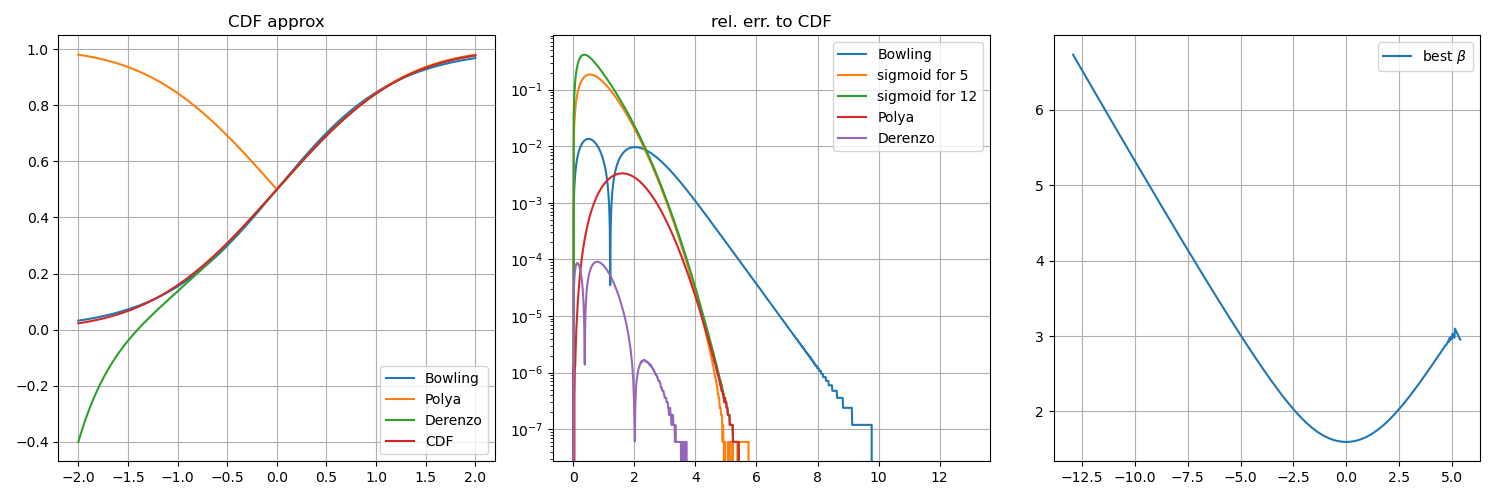

best beta for 4: 2.5897222 4.5: 2.7944643 5: 3.0129995 12: 6.2842226 12.5: 6.5260773 13: inf


In [39]:
# cf. http://www.aimspress.com/article/doi/10.3934/math.2022648
def Bowling(x, beta=1.702):
    return 1 / (1 + jnp.exp( - beta * x))

def Polya(x):
    return 1/2 * (1 + (1 -jnp.exp(- 2 * x**2 / jnp.pi))**0.5)

def Derenzo(x):
    expo = - ((83*x + 351)*x + 562) / (703/x + 165)
    return 1 - jnp.exp(expo) / 2

def best_beta(x):
    return -1/x * jnp.log(1/norm.cdf(x) - 1)

plt.figure(figsize=(15,5))
plt.subplot(131)
xs = jnp.linspace(-2,2, 1000)
plt.plot(xs, Bowling(xs), label="Bowling")
plt.plot(xs, Polya(xs), label="Polya")
plt.plot(xs, Derenzo(xs), label="Derenzo")
plt.plot(xs, norm.cdf(xs), label="CDF")
plt.title("CDF approx")
plt.grid(), plt.legend()
plt.subplot(132)
xs = jnp.linspace(0,13, 1000)
relerr = lambda x, t: jnp.abs(x-t)/jnp.abs(t)
plt.semilogy(xs, relerr(Bowling(xs),norm.cdf(xs)), label="Bowling")
plt.plot(xs, relerr(1-Bowling(-xs, beta=3.0129995),norm.cdf(xs)), label="sigmoid for 5")
plt.plot(xs, relerr(1-Bowling(-xs, beta=6.2842226),norm.cdf(xs)), label="sigmoid for 12")
plt.plot(xs, relerr(Polya(xs),norm.cdf(xs)) , label="Polya")
plt.plot(xs, relerr(Derenzo(xs),norm.cdf(xs)), label="Derenzo")
plt.title("rel. err. to CDF")
plt.legend(), plt.grid()
plt.subplot(133)
xs = jnp.linspace(-15,8, 1000)
plt.plot(xs, best_beta(xs), label="best $\\beta$")
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.legend(), plt.grid(), plt.show();
print("best beta for 4:",best_beta(4), "4.5:", best_beta(4.5), "5:", best_beta(-5), "12:", best_beta(-12), "12.5:", best_beta(-12.5), "13:", best_beta(-13))

$F_X(x) \simeq \frac 1 {1+ e^{-\beta x}} = \operatorname{sigmo}(\beta x) \implies \operatorname{logit}(F_X(x)) \simeq \beta x \implies \beta \simeq \frac 1 x \operatorname{logit}(F_X(x))$

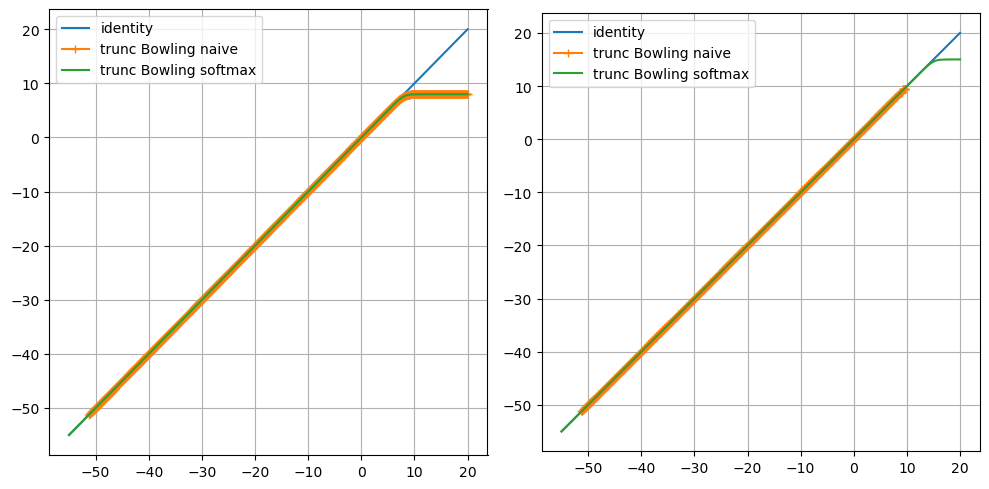

In [20]:
from jax.scipy.special import logsumexp
def Bowling(x):
    return 1 / (1 + jnp.exp( - 1.702 * x))

def invBowling(y):
    return 1/1.702 * jnp.log(y / (1-y))

def trunc_Bowling_naive(x, a=-jnp.inf, b=jnp.inf):
    X, A, B = Bowling(x), Bowling(a), Bowling(b)
    return invBowling(A + (B-A) * X)

def trunc_Bowling_softmax(x, a=-jnp.inf, b=jnp.inf):
    temp = 1/1.702
    energy = jnp.stack(jnp.broadcast_arrays(x, b), axis=0)
    return - temp * logsumexp( - energy / temp, axis=0)

plt.figure(figsize=(10,5))
plt.subplot(121)
xs = jnp.linspace(-55,20, 1000)
plt.plot(xs, xs, '-', label="identity")
b = 8
plt.plot(xs, trunc_Bowling_naive(xs, b=b), '-+', label="trunc Bowling naive")
plt.plot(xs, trunc_Bowling_softmax(xs, b=b), '-', label="trunc Bowling softmax")
plt.grid(), plt.legend();
plt.subplot(122)
plt.plot(xs, xs, '-', label="identity")
b = 15
plt.plot(xs, trunc_Bowling_naive(xs, b=b), '-+', label="trunc Bowling naive")
plt.plot(xs, trunc_Bowling_softmax(xs, b=b), '-', label="trunc Bowling softmax")
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.grid(), plt.legend();

### Non-naive Normal Trunctation

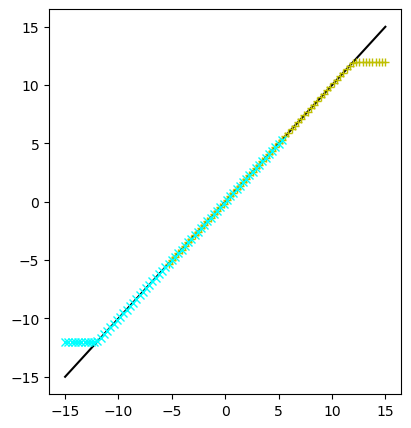

In [3]:
def naive_norm2trunc(x, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    u = norm.cdf(x, loc, scale)
    cdf_low, cdf_high = norm.cdf(low, loc, scale), norm.cdf(high, loc, scale)
    cdf_y = cdf_low + (cdf_high - cdf_low) * u
    return norm.ppf(cdf_y, loc, scale)

def naive2_norm2trunc(x, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    _1mu = norm.cdf(-x, loc, scale)
    cdf_1mlow, cdf_1mhigh = norm.cdf(-low, loc, scale), norm.cdf(-high, loc, scale)
    cdf_1my = cdf_1mhigh - (cdf_1mhigh - cdf_1mlow) * _1mu
    return - norm.ppf(cdf_1my, loc, scale)

xs = jnp.linspace(-15, 15, 100)
plt.figure(figsize=(10,5))
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
a, b = -12, 12
plt.plot(xs, naive2_norm2trunc(xs, 0, 1, low=a, high=b), '+', color='y', label="naive norm2trunc", zorder=np.inf)
plt.plot(xs, naive_norm2trunc(xs, 0, 1, low=a, high=b), 'x', color='cyan', label="naive norm2trunc", zorder=np.inf);

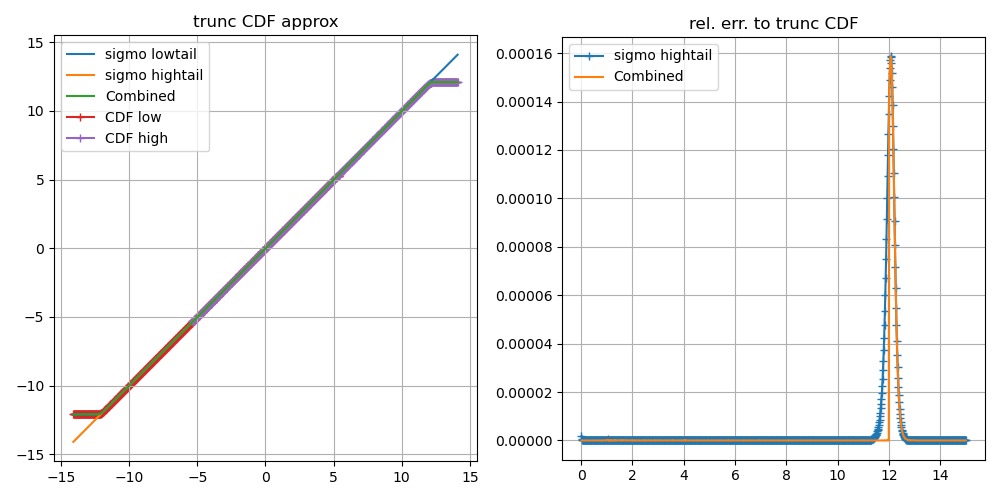

In [162]:
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm
# %matplotlib widget

def lowtail(x, low=-jnp.inf, high=None):
    # temp = 1/1.702 # best temperature for norm inf, i.e. Bowling approx
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = - jnp.stack(jnp.broadcast_arrays(x, low), axis=0)
    return temp * logsumexp( - energy / temp, axis=0)

def hightail(x, low=None, high=jnp.inf):
    # temp = 1/1.702 # best temperature for norm inf, i.e. Bowling approx
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = jnp.stack(jnp.broadcast_arrays(x, high), axis=0)
    return - temp * logsumexp( - energy / temp, axis=0)

def lowbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_low, cdf_high = norm.cdf(low), norm.cdf(high)
    cdf_y = cdf_low + (cdf_high - cdf_low) * norm.cdf(x)
    return norm.ppf(cdf_y)

def highbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_nlow, cdf_nhigh = norm.cdf(-low), norm.cdf(-high)
    cdf_ny = cdf_nhigh - (cdf_nhigh - cdf_nlow) * norm.cdf(-x)
    return - norm.ppf(cdf_ny)

def body(x, low=-jnp.inf, high=jnp.inf):
    condlist = [x < 0]
    funclist = [lowbody, highbody]
    return jnp.piecewise(x, condlist, funclist, low=low, high=high)    

def norm2trunc(x, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    x, low, high = (x - loc) / scale, (low - loc) / scale, (high - loc) / scale
    lim = 12
    condlist = [(x < -lim) & (low < -lim), (lim < x) & (lim < high)]
    funclist = [lowtail, hightail, body]
    return loc + scale * jnp.piecewise(x, condlist, funclist, low=low, high=high)

plt.figure(figsize=(10,5))
plt.subplot(121)
mean, std = 0, 1 
a, b = -5.1, 5.1
a, b = -12.1, 12.1
# a, b = -11.9, 11.9
xs = jnp.linspace(a-2,b+2, 1000)
plt.plot(xs, lowtail(xs, low=a), label="sigmo lowtail")
plt.plot(xs, hightail(xs, high=b), label="sigmo hightail")
plt.plot(xs, norm2trunc(xs, mean, std, low=a, high=b), label="Combined")
plt.plot(xs, lowbody(xs, low=a, high=b), '+-', label="CDF low", zorder=-1)
plt.plot(xs, highbody(xs, low=a, high=b), '+-', label="CDF high", zorder=-1)
plt.title("trunc CDF approx")
plt.grid(), plt.legend()
plt.subplot(122)
xs = jnp.linspace(0,15, 1000)
relerr = lambda x, t: jnp.abs(x-t)/jnp.abs(t)
plt.plot(xs, relerr(hightail(xs, high=b), highbody(xs, low=a, high=b)), '-+', label="sigmo hightail")
plt.plot(xs, relerr(norm2trunc(xs, low=a, high=b), highbody(xs, low=a, high=b)), label="Combined")
plt.title("rel. err. to trunc CDF")
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.legend(), plt.grid(), plt.show();

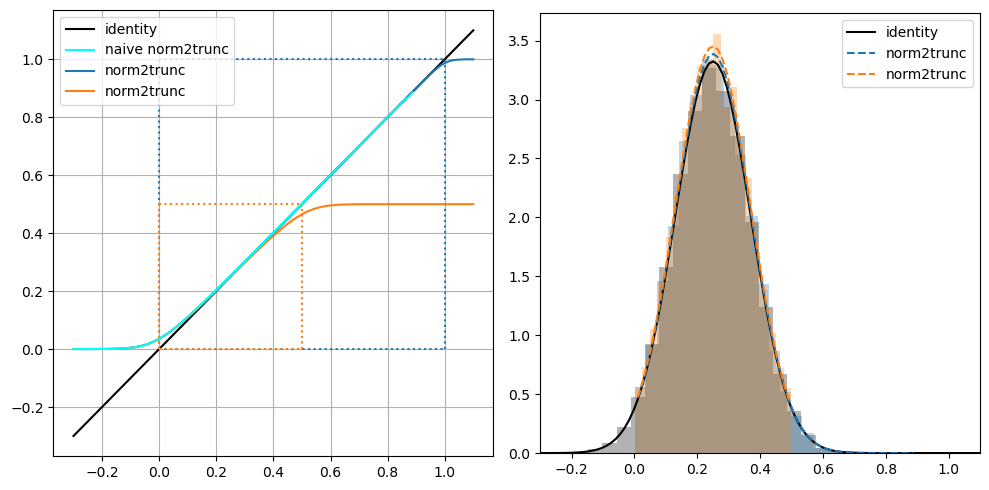

In [53]:
%matplotlib inline
from jax.scipy.stats import norm
def naive_norm2trunc(x, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    u = norm.cdf(x, loc, scale)
    cdf_low, cdf_high = norm.cdf(low, loc, scale), norm.cdf(high, loc, scale)
    cdf_y = cdf_low + (cdf_high - cdf_low) * u
    return norm.ppf(cdf_y, loc, scale)

def trunc2norm(y, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    cdf_y = norm.cdf(y, loc, scale)
    cdf_low, cdf_high = norm.cdf(low, loc, scale), norm.cdf(high, loc, scale)
    u = (cdf_y - cdf_low) / (cdf_high - cdf_low)
    return norm.ppf(u, loc, scale)

def pdf_norm2trunc(pdf, y, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    grad_fn = vmap(grad(partial(norm2trunc, loc=loc, scale=scale, low=low, high=high)))
    x = trunc2norm(y, loc, scale, low, high)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = 0.25, 0.12
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = mean + std * jr.normal(jr.key(42), shape=(10000,))
intervals = [[0, 1], [0,0.5]]
# intervals = [[0, 1]]

xs = jnp.linspace(-0.3,1.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
plt.plot(xs, naive_norm2trunc(xs, mean, std, intervals[0][0], intervals[0][1]), color='cyan', label="naive norm2trunc", zorder=np.inf)
for i, (a, b) in enumerate(intervals):
    plt.plot(xs, norm2trunc(xs, mean, std, a, b), color=color[i+1], label="norm2trunc")
    plt.hlines([a,b], a, b, color=color[i+1], linestyles=':')
    plt.vlines([a,b], a, b, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(xs, pdf_fn(xs), color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    plt.hist(norm2trunc(samples, mean, std, a, b), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(xs, pdf_norm2trunc(pdf_fn, xs, mean, std, a, b), '--', color=color[i+1], label="norm2trunc")
plt.legend()
plt.xlim(xs.min(), xs.max())
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

### Logit of truncated normal
* NumPyro handles finite support with `biject_to`, e.g. with a logit pull/sigmoid push.
* For truncated normal $Y \sim \mathcal N(\mu, \sigma^2, a, b)$, typically pull with $Y = a + (b-a) \operatorname{sigmo(Z)}$, i.e. push with $Z = \operatorname{logit}\left(\frac{Y-a}{b-a}\right)$  
* Let's see what $Z$ looks like.

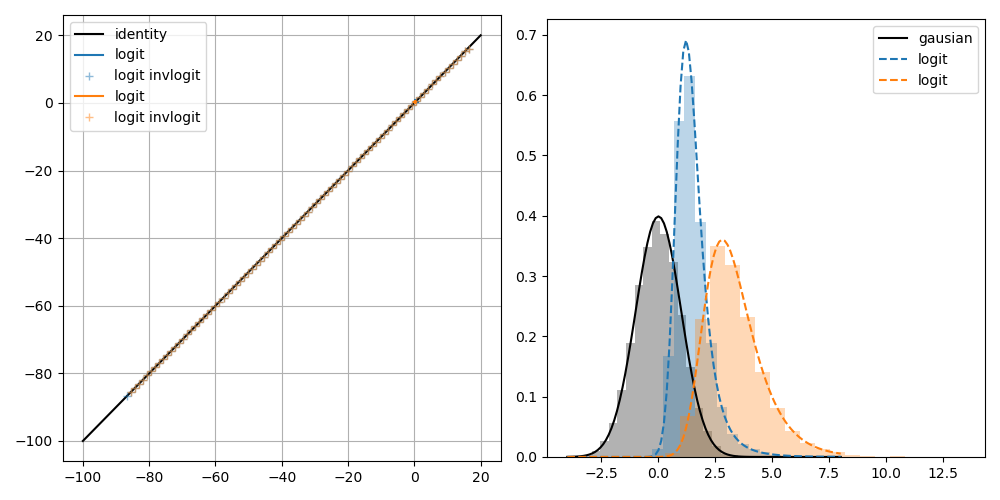

In [151]:
def logit_push(y, a, b):
    y = (y - a) / (b - a)
    return -jnp.log(1/y -1)

def invlogit_push(z, a, b):
    y = 1 / (1+jnp.exp(-z))
    return a + (b-a) * y

def pdf_logit_push(pdf, y, a, b):
    grad_fn = vmap(grad(partial(logit_push, a=a, b=b)))
    x = invlogit_push(y, a, b)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = .25, 0.1
mean, std = .8, 0.1
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples_stand = jr.normal(jr.key(42), shape=(10000,))
samples = mean + std * samples_stand
intervals = [[0,1], [0,.5]]

xs = jnp.linspace(-0.6, 1.1, 100)
xs = jnp.linspace(-100, 20, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    trunc_xs = norm2trunc(xs, mean, std, a, b)
    plt.plot(xs, logit_push(xs, a, b), color=color[i+1], label="logit")
    plt.plot(xs, logit_push(invlogit_push(xs, a, b), a, b), '+', alpha=0.5, color=color[i+1], label="logit invlogit")
    # plt.plot(xs, logit_push(trunc_xs, a, b), color=color[i+1], label="logit trunc")
    plt.hlines([a,b], a, b, color=color[i+1], linestyles=':')
    plt.vlines([a,b], a, b, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
xs = jnp.linspace(-4,8, 100)
plt.hist(samples_stand, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(xs, norm.pdf(xs), color=color[0], label="gausian")
for i, (a, b) in enumerate(intervals):
    trunc_samples = norm2trunc(samples, mean, std, a, b)
    trunc_pdf = lambda x: pdf_norm2trunc(pdf_fn, x, mean, std, a, b)
    # plt.hist(trunc_samples, color=color[i+1], alpha=alpha, density=True, bins=20)
    # plt.plot(xs, trunc_pdf(xs), '--', color=color[i+1], label="norm2trunc")
    plt.hist(logit_push(trunc_samples, a, b), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(xs, pdf_logit_push(trunc_pdf, xs, a, b), '--', color=color[i+1], label="logit")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

### Tanh

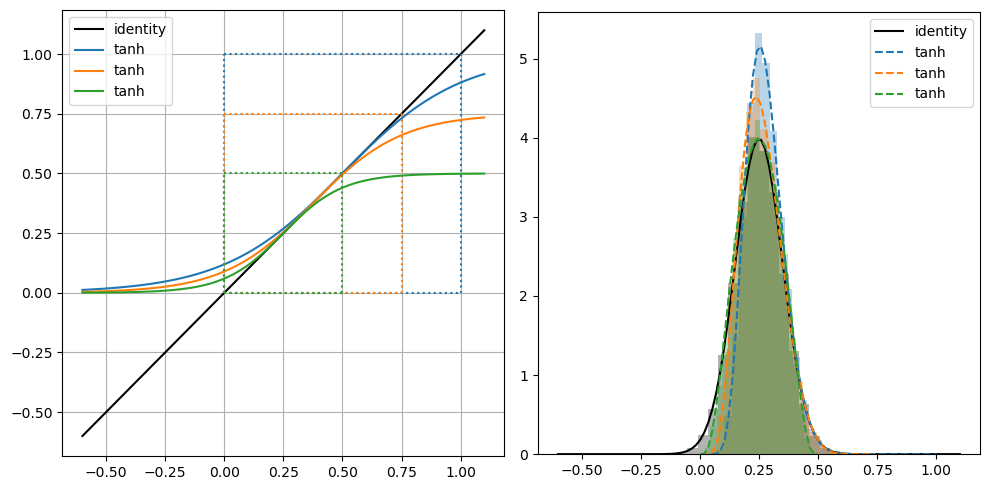

In [148]:
from scipy.stats import norm
from functools import partial

def tanh_push(x, a, b):
    m, d = (b+a)/2, (b-a)/2
    return d * jnp.tanh( (x-m)/d ) + m

def invtanh_push(y, a, b):
    m, d = (b+a)/2, (b-a)/2
    return d * jnp.arctanh( (y-m)/d ) + m

def pdf_tanh_push(pdf, y, a, b):
    grad_fn = vmap(grad(partial(tanh_push, a=a, b=b)))
    x = invtanh_push(y, a, b)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = 0.25, 0.1
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = norm.rvs(mean, std, size=10000)
intervals = [[0, 1], [0,0.75], [0,0.5]]

xs = jnp.linspace(-0.6,1.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    plt.plot(xs, tanh_push(xs, a, b), color=color[i+1], label="tanh")
    plt.hlines([a,b], a, b, color=color[i+1], linestyles=':')
    plt.vlines([a,b], a, b, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(xs, pdf_fn(xs), color=color[0], label="identity")
for i, (a, b) in enumerate(intervals):
    plt.hist(tanh_push(samples, a, b), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(xs, pdf_tanh_push(pdf_fn, xs, a, b), '--', color=color[i+1], label="tanh")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

### Algebraic sigmoid

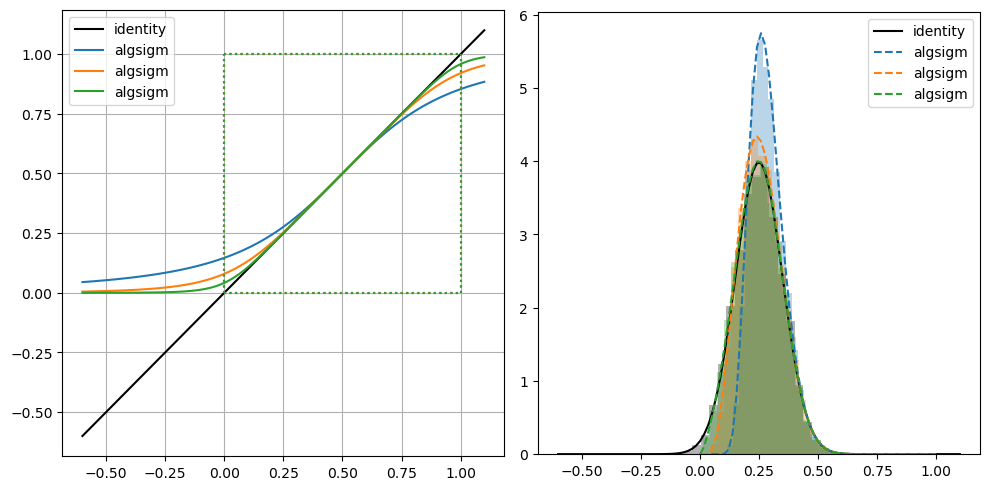

In [126]:
def algsigmoid(x, k:int=1):
    return x / (1 + x**(2*k)) ** (1/(2*k))
    # return x / jnp.maximum(1, jnp.abs(x))

def invalgsigmoid(y, k:int=1):
    return y / (1 - y**(2*k)) ** (1/(2*k))

def algsigmoid_push(x, a, b, k):
    m, d = (b+a)/2, (b-a)/2
    return d * algsigmoid((x-m)/d, k) + m

def invalgsigmoid_push(y, a, b, k):
    m, d = (b+a)/2, (b-a)/2
    return d * invalgsigmoid((y-m)/d, k) + m

def pdf_algsigmoid_push(pdf, y, a, b, k:int=1):
    grad_fn = vmap(grad(partial(algsigmoid_push, a=a, b=b, k=k)))
    x = invalgsigmoid_push(y, a, b, k)
    return pdf(x) / jnp.abs(grad_fn(x))


mean, std = 0.25, 0.1
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = norm.rvs(mean, std, size=10000)
# intervals = [[0, 1], [0,0.75], [0,0.5]]
a, b = 0, 1
hardness = [1,2,4]

xs = jnp.linspace(-0.6,1.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
# for i, (a, b) in enumerate(intervals):
for i, k in enumerate(hardness):
    plt.plot(xs, algsigmoid_push(xs, a, b, k), color=color[i+1], label="algsigm")
    plt.hlines([a,b], a, b, color=color[i+1], linestyles=':')
    plt.vlines([a,b], a, b, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(xs, pdf_fn(xs), color=color[0], label="identity")
# for i, (a, b) in enumerate(intervals):
for i, k in enumerate(hardness):
    plt.hist(algsigmoid_push(samples, a, b, k), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(xs, pdf_algsigmoid_push(pdf_fn, xs, a, b, k), '--', color=color[i+1], label="algsigm")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

### Softplus

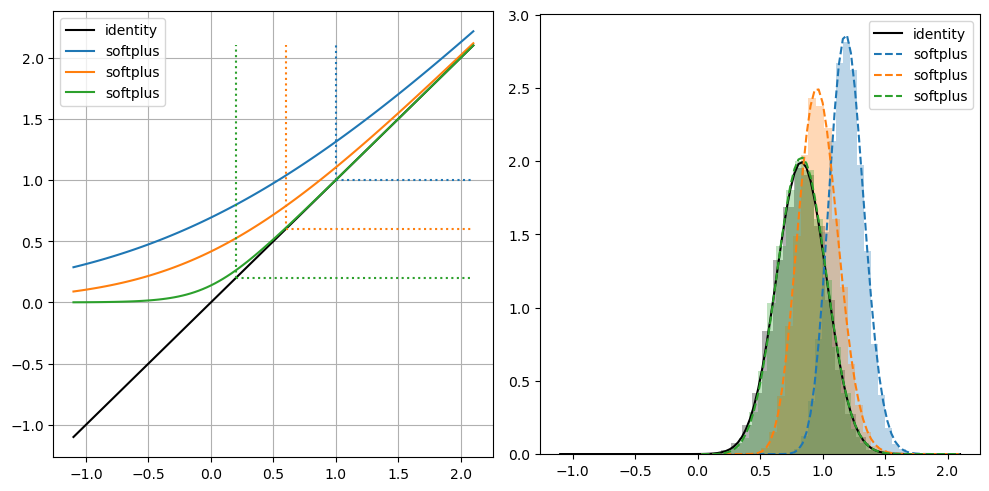

In [5]:
def softplus_push(x, s):
    return jnp.log(jnp.exp(x / s) + 1) * s

def invsoftplus_push(y, s):
    return jnp.log(jnp.exp(y / s) - 1) * s

def pdf_softplus_push(pdf, y, s):
    grad_fn = vmap(grad(partial(softplus_push, s=s)))
    x = invsoftplus_push(y, s)
    return pdf(x) / jnp.abs(grad_fn(x))

mean, std = 0.831, 0.2
pdf_fn = lambda x: norm.pdf(x, mean, std)
samples = norm.rvs(mean, std, size=10000)
softness = [1, 0.6, 0.2]
# softness = [1, 2/3, 1/3]

xs = jnp.linspace(-1.1,2.1, 100)
plt.figure(figsize=(10,5))
alpha = 0.3
# color = ['k', 'purple','orange','forestgreen']
color = ['k']+[f"C{i}" for i in range(5)]
plt.subplot(121)
plt.plot(xs, xs, color=color[0], label="identity")
for i, s in enumerate(softness):
    plt.plot(xs, softplus_push(xs, s), color=color[i+1], label="softplus")
    xmax = xs.max()
    plt.hlines([s], s, xmax, color=color[i+1], linestyles=':')
    plt.vlines([s], s, xmax, color=color[i+1], linestyles=':')
from matplotlib.lines import Line2D
handles, _ = plt.gca().get_legend_handles_labels()
# handles.append(Line2D([], [], color='grey', linestyle=':', label='approx region'))
plt.legend(handles=handles), plt.grid()

plt.subplot(122)
plt.hist(samples, alpha=alpha, color=color[0], density=True, bins=20)
plt.plot(xs, pdf_fn(xs), color=color[0], label="identity")
for i, s in enumerate(softness):
    plt.hist(softplus_push(samples, s), color=color[i+1], alpha=alpha, density=True, bins=20)
    plt.plot(xs, pdf_softplus_push(pdf_fn, xs, s), '--', color=color[i+1], label="softplus")
plt.legend()
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

### Hardened sigmoid, composedexp, dualsoftplus...

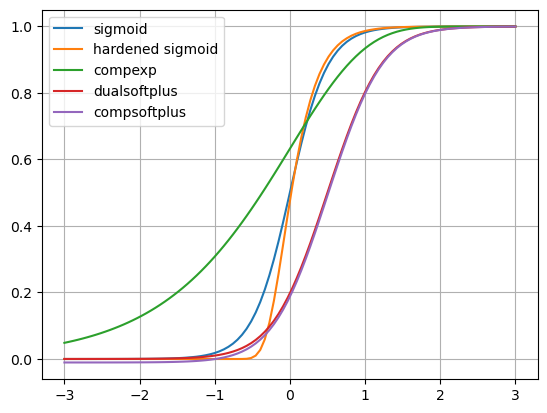

In [74]:
# Sigmoid to some power is not a symmetrical way to make a hardened sigmoid
def sigmoid(x):
    return 1 / (1 + jnp.exp(- 4 * (x)))

def sigmoid_push(x, s):
    return sigmoid( x) ** s

def composedexp(x, low, high):
    return high - (high - low) * jnp.exp(-jnp.exp(x))

def dualsoftplus_push(x, a, b, s):
    return a + jnp.log( (jnp.exp((x - a) / s) + 1) / (jnp.exp((x - b) / s) + 1) ) * s

def softplus_push(x, s):
    return jnp.log(jnp.exp(x / s) + 1) * s

def composoftplus_push(x, a, b, s):
    overa = a + softplus_push( (x - a), s)
    underb = b - softplus_push(b - overa, s)
    return  underb

softness = 1000
xs = np.linspace(-3,3, 100)
plt.plot(xs, sigmoid_push(xs, 1), label="sigmoid")
plt.plot(xs, sigmoid_push(xs+1.8, softness), label="hardened sigmoid")
plt.plot(xs, composedexp(xs, 0,1), label="compexp")
plt.plot(xs, dualsoftplus_push(xs, 0,1, 0.3), label="dualsoftplus")
plt.plot(xs, composoftplus_push(xs, 0,1, 0.3), label="compsoftplus")
plt.legend(), plt.grid(), plt.show();

## NumPyro interval reparam comparison
* With MH: rejection
* With HMC/NUTS: `biject_to`, with sigmoid
* We can implement our own repram with stdnorm2trunc

In [235]:
from jax.scipy.special import logsumexp
from jax.scipy.stats import norm

def lowtail(x, low=-jnp.inf, high=None):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = - jnp.stack(jnp.broadcast_arrays(x, low), axis=0)
    return temp * logsumexp( - energy / temp, axis=0)

def hightail(x, low=None, high=jnp.inf):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy = jnp.stack(jnp.broadcast_arrays(x, high), axis=0)
    return - temp * logsumexp( - energy / temp, axis=0)

def lowbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_low, cdf_high = norm.cdf(low), norm.cdf(high)
    cdf_y = cdf_low + (cdf_high - cdf_low) * norm.cdf(x)
    return norm.ppf(cdf_y)

def highbody(x, low=-jnp.inf, high=jnp.inf):
    cdf_nlow, cdf_nhigh = norm.cdf(-low), norm.cdf(-high) # cdf(-x) = 1-cdf(x), but more stable
    cdf_ny = cdf_nhigh - (cdf_nhigh - cdf_nlow) * norm.cdf(-x)
    return - norm.ppf(cdf_ny)

def body(x, low=-jnp.inf, high=jnp.inf):
    condlist = [x < 0]
    funclist = [lowbody, highbody]
    return jnp.piecewise(x, condlist, funclist, low=low, high=high)    

def std2trunc(x, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    low, high = (low - loc) / scale, (high - loc) / scale
    lim = 12
    condlist = [(x < -lim) & (low < -lim), (lim < x) & (lim < high)]
    funclist = [lowtail, hightail, body]
    return loc + scale * jnp.piecewise(x, condlist, funclist, low=low, high=high)

 


def invlowbody(y, low=-jnp.inf, high=jnp.inf):
    cdf_low, cdf_high = norm.cdf(low), norm.cdf(high)
    cdf_x = (norm.cdf(y) - cdf_low) / (cdf_high - cdf_low)
    return norm.ppf(cdf_x)

def invhighbody(y, low=-jnp.inf, high=jnp.inf):
    cdf_nlow, cdf_nhigh = norm.cdf(-low), norm.cdf(-high) # cdf(-x) = 1-cdf(x), but more stable
    cdf_nx = (cdf_nhigh - norm.cdf(-y)) / (cdf_nhigh - cdf_nlow)
    return - norm.ppf(cdf_nx)

def invbody(y, low=-jnp.inf, high=jnp.inf):
    condlist = [y < 0]
    funclist = [invlowbody, invhighbody]
    return jnp.piecewise(y, condlist, funclist, low=low, high=high)   

def invhightail(y, low=None, high=jnp.inf):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy, b = jnp.split(jnp.stack(jnp.broadcast_arrays(y, high, 1, -1), axis=0), 2)
    return - temp * logsumexp( - energy / temp, axis=0, b=b)

def invlowtail(y, low=-jnp.inf, high=None):
    temp = 1/6.2842226/2 # best temperature at 12 sigma
    energy, b = jnp.split(jnp.stack(jnp.broadcast_arrays(-y, -low, 1, -1), axis=0), 2)
    return temp * logsumexp( - energy / temp, axis=0, b=b)

def trunc2std(y, loc=0, scale=1, low=-jnp.inf, high=jnp.inf):
    y, low, high = (y - loc) / scale, (low - loc) / scale, (high - loc) / scale
    lim = 12
    condlist = [(y < -lim) & (low < -lim), (lim < y) & (lim < high)]
    funclist = [invlowtail, invhightail, invbody]
    return jnp.piecewise(y, condlist, funclist, low=low, high=high)

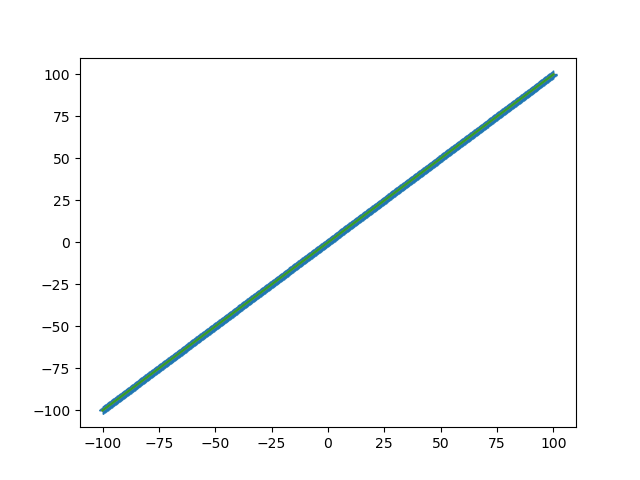

In [234]:
%matplotlib widget
xs = jnp.linspace(-100,100, 1000)
a, b = -10, 10
a, b = -20, 20
a, b = -jnp.inf, jnp.inf
plt.figure()
# plt.plot(xs, invlowbody(xs, low=a, high=b), '-+')
# plt.plot(xs, lowbody(xs, low=a, high=b))
# plt.plot(xs, invlowbody(lowbody(xs, low=a, high=b), low=a, high=b))
# plt.plot(xs, lowbody(invlowbody(xs, low=a, high=b), low=a, high=b))
# plt.plot(xs, invhighbody(xs, low=a, high=b), '-+')
# plt.plot(xs, highbody(xs, low=a, high=b))
# plt.plot(xs, invhighbody(highbody(xs, low=a, high=b), low=a, high=b))
# plt.plot(xs, highbody(invhighbody(xs, low=a, high=b), low=a, high=b))
# plt.plot(xs, invbody(xs, low=a, high=b), '-+')
# plt.plot(xs, body(xs, low=a, high=b))
# plt.plot(xs, invbody(body(xs, low=a, high=b), low=a, high=b))
# plt.plot(xs, body(invbody(xs, low=a, high=b), low=a, high=b))
plt.plot(xs, trunc2std(xs, low=a, high=b), '-+')
# plt.plot(xs, std2trunc(xs, low=a, high=b))
plt.plot(xs, trunc2std(std2trunc(xs, low=a, high=b), low=a, high=b))
plt.plot(xs, std2trunc(trunc2std(xs, low=a, high=b), low=a, high=b))

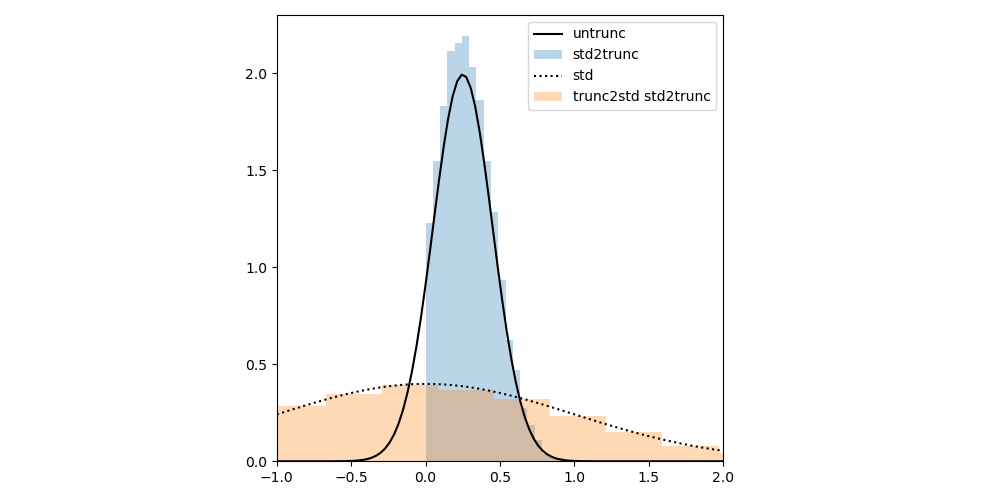

In [246]:
mean, std = 0.25, 0.2
a, b = 0, 1 
pdf_fn = lambda x: norm.pdf(x, mean, std)
pdf_std_fn = lambda x: norm.pdf(x)
samples = jr.normal(jr.key(42), shape=(10000,))
trunc_samples = std2trunc(samples, mean, std, a, b)
untrunc_samples = trunc2std(trunc_samples, mean, std, a, b)

alpha = 0.3
color = ['k']+[f"C{i}" for i in range(5)]
xs = jnp.linspace(a-1,b+1, 100)
plt.figure(figsize=(10,5))
plt.plot(xs, pdf_fn(xs), color=color[0], label="untrunc")
plt.hist(trunc_samples, alpha=alpha, color=color[1], density=True, bins=20, label="std2trunc")
plt.plot(xs, pdf_std_fn(xs), ':', color=color[0], label="std")
plt.hist(untrunc_samples, alpha=alpha, color=color[2], density=True, bins=20, label="trunc2std std2trunc")
plt.legend()
plt.xlim(xs.min(), xs.max())
plt.gca().set_box_aspect(1.0), plt.tight_layout()
plt.show()

In [247]:
def model(n, low=0, high=1):
    x = sample('x', dist.TruncatedNormal(0.25, 0.2, low=low, high=high))
    with plate(f"n={n}", n):
        y = sample('y', dist.Normal(loc=x, scale=1))
    return y

def model_rep(n, low=0, high=1):
    x_ = sample('x_', dist.Normal(0,1))
    x = deterministic('x', std2trunc(x_, 0.25, 0.2, low=low, high=high))
    with plate(f"n={n}", n):
        y = sample('y', dist.Normal(loc=x, scale=1))
    return y

n = 10
model = partial(model, n=n)
fiduc = {'x':0.25}
obs = {'y':seed(condition(model, fiduc), 42)()}
obs_model = condition(model, obs)
obs_model_uncons = partial(obs_model, low=-5, high=6)
# obs_model_uncons = partial(obs_model, low=-1000, high=1000) # Awful results, just test and you will see

numpyro.render_model(obs_model, render_distributions=True, render_params=True,)

AttributeError: module 'jax.core' has no attribute 'safe_map'

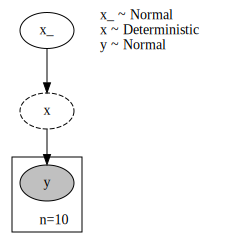

In [136]:
model_rep = partial(model_rep, n=n)
fiduc = {'x_':0.}
obs_rep = {'y':seed(condition(model_rep, fiduc), 42)()}
obs_model_rep = condition(model_rep, obs)
obs_model_uncons_rep = partial(obs_model_rep, low=-jnp.inf, high=jnp.inf)

numpyro.render_model(obs_model_rep, render_distributions=True, render_params=True,)

In [138]:
from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm as MALA, RandomWalkMetropolis as MH
from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
def split_like(key, target):
    treedef = tree_structure(target)
    keys = jr.split(key, treedef.num_leaves)
    return tree_unflatten(treedef, keys)

def new_state_fn(state, key):
    # diffus = dist.Normal(jnp.zeros(1), 0.1*jnp.ones(1)).sample(key)
    # return tree_map(lambda x,y:x+y, state, [diffus])
    key_tree = split_like(key, state)
    diffus = tree_map(lambda x, k: dist.Normal(jnp.zeros_like(x), 0.1 * jnp.ones_like(x)).sample(k), state, key_tree)
    return tree_map(lambda x,y:x+y, state, diffus)

# Sample from posterior
mh_kernel = MH(model=obs_model_uncons, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples_uncons = mcmc.get_samples()
mcmc.print_summary()

mh_kernel = MH(model=obs_model, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples = mcmc.get_samples()
mcmc.print_summary()

mh_kernel = MH(model=obs_model_uncons_rep, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples_uncons_rep = mcmc.get_samples()
mcmc.print_summary()

mh_kernel = MH(model=obs_model_rep, init_strategy=infer.init_to_value(values=fiduc), new_state_fn=new_state_fn,)
mcmc = infer.MCMC(mh_kernel, num_warmup=1000, num_samples=10000, progress_bar=True)
mcmc.run(jr.key(42))
mh_samples_rep = mcmc.get_samples()
mcmc.print_summary()

/tmp/ipykernel_2728702/971705880.py:2: DeprecationWarning: jax.tree_unflatten is deprecated: use jax.tree.unflatten (jax v0.4.25 or newer) or jax.tree_util.tree_unflatten (any JAX version).
  from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
/tmp/ipykernel_2728702/971705880.py:2: DeprecationWarning: jax.tree_structure is deprecated: use jax.tree.structure (jax v0.4.25 or newer) or jax.tree_util.tree_structure (any JAX version).
  from jax import numpy as jnp, random as jr, tree_unflatten, tree_structure
sample: 100%|██████████| 11000/11000 [00:04<00:00, 2401.64it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.20      0.17      0.20     -0.07      0.48   2063.07      1.00



sample: 100%|██████████| 11000/11000 [00:03<00:00, 2821.39it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.21      0.14      0.20      0.02      0.39     30.87      1.09



sample: 100%|██████████| 11000/11000 [00:05<00:00, 2087.27it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x_     -0.37      0.80     -0.35     -1.76      0.88     40.63      1.07



sample: 100%|██████████| 11000/11000 [00:05<00:00, 2082.72it/s]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x_     -0.43      0.84     -0.41     -1.85      0.88     36.85      1.07



In [139]:
nuts_kernel = infer.NUTS(obs_model_uncons, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_uncons, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

nuts_kernel = infer.NUTS(obs_model, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

nuts_kernel = infer.NUTS(obs_model_uncons_rep, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_uncons_rep, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

nuts_kernel = infer.NUTS(obs_model_rep, step_size=0.1, init_strategy=infer.init_to_value(values=fiduc),)
mcmc =  infer.MCMC(nuts_kernel, num_warmup=350, num_samples=3500, progress_bar=True)
mcmc.run(jr.key(43), extra_fields=['num_steps'])
samples_rep, extra = mcmc.get_samples(), mcmc.get_extra_fields()
print("total steps:", extra['num_steps'].sum())
mcmc.print_summary()

sample: 100%|██████████| 3850/3850 [00:10<00:00, 360.18it/s, 1 steps of size 9.55e-01. acc. prob=0.94]


total steps: 9512

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.20      0.17      0.20     -0.05      0.49   1567.52      1.00

Number of divergences: 0


sample: 100%|██████████| 3850/3850 [00:09<00:00, 386.44it/s, 1 steps of size 1.14e+00. acc. prob=0.87]


total steps: 8210

                mean       std    median      5.0%     95.0%     n_eff     r_hat
         x      0.23      0.14      0.22      0.00      0.43   1024.65      1.00

Number of divergences: 0


sample: 100%|██████████| 3850/3850 [00:09<00:00, 385.55it/s, 1 steps of size 1.03e+00. acc. prob=0.94]


total steps: 9828

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x_     -0.24      0.83     -0.25     -1.57      1.16   1533.69      1.00

Number of divergences: 0


sample: 100%|██████████| 3850/3850 [00:09<00:00, 402.94it/s, 1 steps of size 1.34e+00. acc. prob=0.90]


total steps: 8000

                mean       std    median      5.0%     95.0%     n_eff     r_hat
        x_     -0.26      0.86     -0.27     -1.71      1.12   1283.36      1.00

Number of divergences: 0


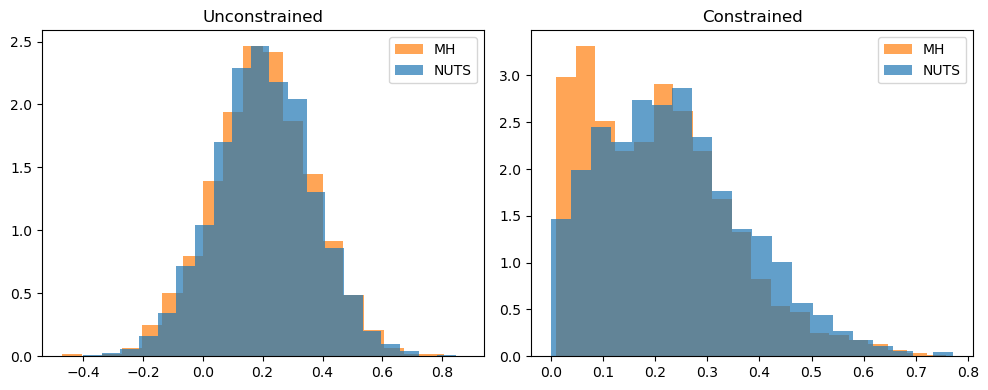

In [133]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(mh_samples_uncons['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples_uncons['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Unconstrained"), plt.legend()
plt.subplot(122)
plt.hist(mh_samples['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Constrained"), plt.legend()
plt.tight_layout(), plt.show();

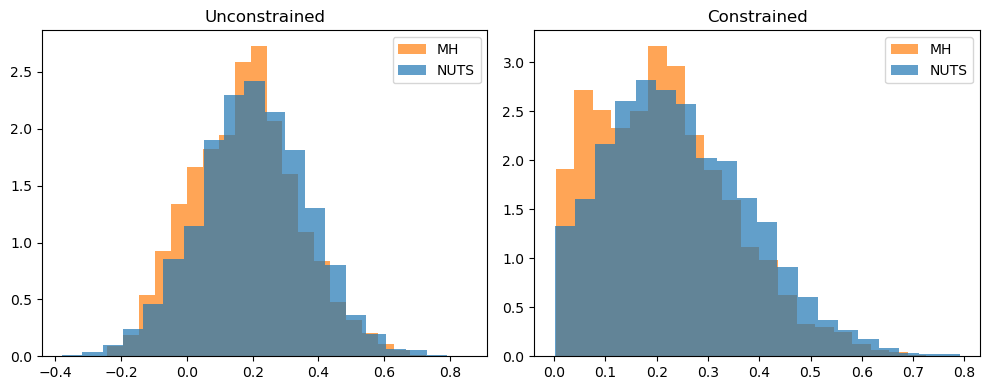

In [140]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.hist(mh_samples_uncons_rep['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples_uncons_rep['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Unconstrained"), plt.legend()
plt.subplot(122)
plt.hist(mh_samples_rep['x'], density=True, color='tab:orange', alpha=0.7, bins=20, label="MH")
plt.hist(samples_rep['x'], density=True, color='tab:blue', alpha=0.7, bins=20, label="NUTS")
plt.title("Constrained"), plt.legend()
plt.tight_layout(), plt.show();